Slide 1
<!--- ![](../reports/presentations/20231205/1.png) -->

# Pipeline

Slides 2-4
<!--- ![](../reports/presentations/20231205/2.png)
![](../reports/presentations/20231205/3.png)
![](../reports/presentations/20231205/4.png)--->

## Setup

### Imports

In [1]:
# External imports
import os
import sys
import spacy


# Get the current working directory (assuming the notebook is in the notebooks folder)
current_dir = os.getcwd()

# Add the parent directory (project root) to the Python path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# Relative imports
from src.utils import ld_spcy_mdl
from src.preprocess import Preprocessor
from src.modelling import search_constraints_in_data
from src.evaluation import cnstrnts_gs, sbert_smlarty, sbert_smlarty_cmpntns, evlt_prec_rec

/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Files

In [2]:
# Define variables to use as keys
aktg = "AktG"
cdm_01 = "CDM 01: A/R Mangroves"
cdm_02 = "CDM 02: A/R Non-wetlands"
cdm_03 = "CDM 03: Cable Cars"
cdm_04 = "CDM 04: Energy Efficiency"
cdm_05 = "CDM 05: Electriciy Generation"
coffee = "Coffee"
patg = "PatG"

# Define file paths
file_paths_input = {
    aktg: os.path.join('..', 'data', 'aktg', 'input_aktg.txt'),
    cdm_01: os.path.join('..', 'data', 'cdm', 'input_cdm_01.txt'),
    cdm_02: os.path.join('..', 'data', 'cdm', 'input_cdm_02.txt'),
    cdm_03: os.path.join('..', 'data', 'cdm', 'input_cdm_03.txt'),
    cdm_04: os.path.join('..', 'data', 'cdm', 'input_cdm_04.txt'),
    cdm_05: os.path.join('..', 'data', 'cdm', 'input_cdm_05.txt'),  
    coffee: os.path.join('..', 'data', 'coffee', 'input_coffee.txt'),
    patg: os.path.join('..', 'data', 'patg', 'input_patg.txt'),  
}

file_paths_output = {
    aktg: os.path.join('..', 'data', 'aktg', 'output_aktg.txt'),
    cdm_01: os.path.join('..', 'data', 'cdm', 'output_cdm_01.txt'),
    cdm_02: os.path.join('..', 'data', 'cdm', 'output_cdm_02.txt'),
    cdm_03: os.path.join('..', 'data', 'cdm', 'output_cdm_03.txt'),
    cdm_04: os.path.join('..', 'data', 'cdm', 'output_cdm_04.txt'),
    cdm_05: os.path.join('..', 'data', 'cdm', 'output_cdm_05.txt'),  
    coffee: os.path.join('..', 'data', 'coffee', 'output_coffee.txt'),
    patg: os.path.join('..', 'data', 'patg', 'output_patg.txt'),  
}

### Parameter

In [3]:
# spaCy model
model = 'en_core_web_lg'

# Load the spaCy model
nlp = ld_spcy_mdl(model=model)

# Define custom stop words
add_stpwrds = []
non_stpwrds = [
    "a",
    "above",
    "all",
    "amount",
    "and",
    "as",
    "at",
    "be",
    "before",
    "below",
    "between",
    "beyond",
    "both",
    "by",
    "can",
    "each",
    "either",
    "else",
    "even",
    "except",
    "for",
    "i",
    "if",
    "last",
    "least",
    "less",
    "may",
    "more",
    "most",
    "must",
    "name",
    "next",
    "no",
    "none",
    "not",
    "nothing",
    "of",
    "on",
    "only",
    "otherwise",
    "over",
    "or",
    "out",
    "per",
    "several",
    "should",
    "than",
    "then",
    "to",
    "under",
    "up",
    "what",
    "when",
    "with"
]

# This is needed because spaCy struggles with linebreak characters, but the information is needed for the enumeration (see also https://github.com/explosion/spaCy/issues/7735)
linebreak = " NEWLINE "

# Define character sequences to replace
replace = {"\n\n": "\n", 
           "\n \n": "\n",
           "\n \n\n": "\n",
           "\n\n \n": "\n",
           "\n": linebreak,
           "   ": " ",
           "  ": " "} 

# Define character sequences to remove
remove=["\t"]

# Patterns for different enumeration items types for regex matching (to split into chunks)
enum_patterns = {
    'number_in_parentheses': r"\(\d+\)",
    'number_with_dot': r"\d+\.",
    'alphabetical_in_parentheses': r"\([a-z]\)",
    'roman_numeral_in_parentheses': r"\([ivxlcdm]+\)",
}

# Patterns for different enumeration items types for spaCy matching (to label enumeration tokens)
# Every pattern has to follow a linebreak; additionally, the order of the pattern has to be followed (e.g., "v" as alphabetical_in_parentheses can only be a match, if the previous one was also alphabetical_in_parentheses 
enum_patterns_spacy = {
    'number_in_parentheses': lambda: [{"TEXT": "("}, {"IS_DIGIT": True}, {"TEXT": ")"}],
    'number_with_dot': lambda: [{"IS_DIGIT": True}, {"TEXT": "."}, {"IS_DIGIT": False}],
    'alphabetical_in_parentheses': lambda: [{"TEXT": "("}, {"TEXT": {"IN": ["a", "b", "c", "d", "e", "f", "g", "h"]}}, {"TEXT": ")"}],
    'roman_numeral_in_parentheses': lambda: [{"TEXT": "("}, {"TEXT": {"IN": ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii"]}}, {"TEXT": ")"}],
}

no_digit_or_period = [{"TEXT": {"NOT_IN": ["."]}, "IS_DIGIT": False, "OP": "*"}]

# Define inequality matching parameters
inequality_params = {
    "general": {
        "below": "<",
        "less than": "<",
        "low than": "<",
        "small than": "<",
        "as high as": "<=",
        "at most": "<=",
        "up to": "<=",
        "remain at": "<=",
        "eligibility limit of": "<=",
        "above": ">",
        "beyond": ">",
        "exceed": ">",
        "great than": ">",
        "high than": ">",
        "more than": ">",
        "surpass": ">",
        "at least": ">="
    },
    "exceptions": {},
    "exception_patterns": {
    # coffee
    "reach_beyond": lambda: [{"LOWER": "reach"}] + no_digit_or_period + [{"LIKE_NUM": True}] + no_digit_or_period + [{"LOWER": "beyond"}],
    "low_allow": lambda: [{"LOWER": "low"}] + no_digit_or_period + [{"LOWER": "allow"}] + no_digit_or_period + [{"LIKE_NUM": True}],
    "between": lambda: [{"LOWER": "between"}, {"LIKE_NUM": True}] + no_digit_or_period + [{"LIKE_NUM": True}],
    "brackets": lambda: [{"TEXT": "["}, {"LIKE_NUM": True}, {"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"LIKE_NUM": True},{"IS_DIGIT": False, "OP": "*"}, {"TEXT": "]"}],
    "parentheses": lambda: [{"TEXT": "("}, {"LIKE_NUM": True}, {"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"LIKE_NUM": True},{"IS_DIGIT": False, "OP": "*"}, {"TEXT": ")"}]
    },
    "negation_operators": {
        "<": ">=",
        "<=": ">",
        ">": "<=",
        ">=": "<"
    },
    "negation_tokens": {"not", "no"},
    "window_size": (5, 0)
}

# Define equality matching parameters
equality_params = {
    "general": {
        "must": "==",
        "shall": "==",
        "should": "=="
    },
    "exceptions": {
        # aktg
        "be to set out": "==",
        "applicable under": "==",
        # cdm_01
        "apply to": "==",
        # cdm_02
        "applicable to": "==",
        # cdm_03
        "eligible under": "==",
        # cdm_05
        "category comprise": "==",
        "include category": "==",
        "be limit to": "==",
        # patg
        "be to be": "=="
    },
    "exception_patterns": {
    # aktg
    "may_only": lambda: [{"LOWER": "may"}] + no_digit_or_period + [{"LOWER": "only"}],
    # cdm_01
    "fall_in": lambda: [{"LOWER": "fall"}] + no_digit_or_period + [{"LOWER": "category"}],
    # cdm_04
    "none_may": lambda: [{"LOWER": "none"}] + no_digit_or_period + [{"LOWER": "may"}],
    },
    "negation_operators": {
        "==": "!="
    },
    "negation_tokens": {"not", "no"},
    "window_size": (3, 2)
}

# Define meta matching parameters
meta_params = {
    "enum_exceptions": {
        # cdm 05
        "at least one of": "OR",
    },
    "if_patterns": {
        "if_then": lambda: [{"LOWER": "if"}, {"TEXT": {"NOT_IN": [":",".",";"]}, "OP": "*"},{"TEXT": {"IN": [","]}, "OP": "?"}, {"LOWER": "then"}],
        "if_comma": lambda: [{"LOWER": "if"}, {"TEXT": {"NOT_IN": [":",".",";"]}, "OP": "*"},{"TEXT": {"IN": [","]}}, {"TEXT": {"NOT_IN": ["then"]}}]
    },
    "negation_tokens": {"not", "no"}, # Used for if_patterns
    "window_size": (0, 5)             # Used for if_patterns
}


The model en_core_web_lg is already installed!


## Preprocessing

In [4]:
# Create preprocessing object
pp = Preprocessor(nlp, file_paths_input, verbose=False)

# Add and remove custom stop words globally to the spacy.util.get_lang_class('en')
stpwrds = pp.chng_stpwrds(add=add_stpwrds,remove=non_stpwrds, remove_numbers=True)

# Uncomment this line to restore the default set of stpwrds
# stpwrds = chng_stpwrds(restore_default=True, verbose=True)

# Process all files
data = pp.optimized_preprocessing(replace, remove, linebreak, enum_patterns, enum_patterns_spacy)

## Modelling

### Constraint Search

In [5]:
constraints = search_constraints_in_data(nlp, data, equality_params, inequality_params, meta_params, verbose=False)

In [ ]:
# def _build_single_constraint(part, trigger, rules, start, end):
#     """
#     """
#     constraint = ""

#     rule = rules[trigger]
#     left = rule["left"]
#     right = rule["right"]
#     operator = rule["operator"]
    

#     if right == "NUMBER":
#         right = str(5) # TODO: get number from chunk after trigger
    


#     constraint = left + operator + right
#     return constraint

#     return (constraint, start, end)

# def rule_based_constraints(doc, rules, esc='/n'):
#     """
#     Extracts the constraints from the doc object, given the set of rules.
#     :param doc: Preprocessed input as a spaCy doc object.
#     :param rules: Set of rules.
#     :param esc: Character sequence to demark the end of the split.
#     :return: Dictionary with constraints in the format '({PROCESS_STEP_1}, {PROCESS_STEP_2}, {directly follows}, {CONSTRAINT})'. PROCESS_STEP_2 follows PROCESS_STEP_1, if CONSTRAINT is True. Keys are "c{idx}", idx being a running number.
#     """
#     constraints = {}
#     constraints_tmp = {}
#     idx = 1
#     start = 0
    
#     # Split the doc into chunks.
#     chunk, end = _split(doc,start,esc=esc)

#     # Check the chunk for a constraint
#     trigger, level, parts, connector = _check_for_trigger(chunk, rules)

#     # For a meta-rule
#     if trigger:
#         if level == 'meta':
            
#             #TODO

#             pass 
#         else:
#             if connector == 'OR':
#                 for part in parts:
#                     # First, build only the constraint
#                     constraints_tmp[f"c{idx}"] = _build_single_constraint(part, trigger, rules, start, end)
#                     # Increase the index for the key
#                     idx += 1
#             if connector == 'AND':
            

#     # 


## Evaluation

In [ ]:
constraints_dummy_cdm = {
    # Exact match
    "c1": "({check project type}, {check connection type}, {directly follows}, {project type == new installation OR project type == replacing existing fossil-fuel-fired generation})",
    # Close match
    "c2": "({check power plant type}, {check hydro power plant}, {directly follows}, {power plant type == hydro power})",
    # No match
    "c3": "({check combustion}, {check emissions}, {directly follows}, {fuel == coal})"
}
constraints_dummy_cdm = {
    'c1': '({check transport mode}, {check project type}, {directly follows}, {transport_mode == cable_car})',
    'c2': '({check project type}, {verify road accessibility}, {directly follows}, {project_type == new_construction})',
    'c3': '({verify road accessibility}, {assess fuel type}, {directly follows}, {accessibility == accessible_by_road})',
    'c4': '({assess fuel type}, {evaluate baseline scenario}, {directly follows}, {fuel_type in [electricity, gaseous_fossil, liquid_fossil, bio_fuel_blend]})',
    'c5': '({evaluate baseline scenario}, {check emission reduction measures}, {directly follows}, {baseline_scenario == represents_continuation_of_current_transport_system})',
    'c6': '({check emission reduction measures}, {apply methodology}, {directly follows}, {emission_reduction <= 60})'
  }

### Calculating similarity scores

In [ ]:

# Transform content to dictionary
constraints_gs_cdm = cnstrnts_gs(file_paths_output[cdm_03])
constraints_gs_cdm

{'c1': '({check project context}, {check impact on emissions}, {directly follows}, {project_context == substitution})',
 'c2': '({check impact on emissions}, {check accessibility by road}, {directly follows}, {(relevancy_for_trip == part_of_trip OR relevancy_for_trip == total_trip) AND project_type == no_extension})',
 'c3': '({check accessibility by road}, {check compliance of fuels used in baseline or project case}, {directly follows}, {cable_car_accessibility == accessible_by_road})',
 'c4': '({check compliance of fuels used in baseline or project case}, {check emission reductions of measures}, {directly follows}, {fuel_complinace == compliant})',
 'c5': '({check emission reductions of measures}, {apply methodology}, {directly follows}, {annual_emission_reductions <= 60})'}

In [ ]:
similarity_scores = sbert_smlarty(constraints_dummy_cdm, constraints_gs_cdm, model='all-mpnet-base-v2')

for key, value in similarity_scores.items():
    print(f'{key}: {value}')

c1 - c1: 0.21385955810546875
c1 - c2: 0.35957950353622437
c1 - c3: 0.6039201617240906
c1 - c4: 0.2667376399040222
c1 - c5: 0.1387031376361847
c2 - c1: 0.4972173869609833
c2 - c2: 0.5726252198219299
c2 - c3: 0.6562173366546631
c2 - c4: 0.3718118369579315
c2 - c5: 0.18491506576538086
c3 - c1: 0.31267333030700684
c3 - c2: 0.5731697082519531
c3 - c3: 0.7932422757148743
c3 - c4: 0.5343741178512573
c3 - c5: 0.27760469913482666
c4 - c1: 0.43337613344192505
c4 - c2: 0.48290836811065674
c4 - c3: 0.44578421115875244
c4 - c4: 0.6653098464012146
c4 - c5: 0.38735431432724
c5 - c1: 0.467267781496048
c5 - c2: 0.5613568425178528
c5 - c3: 0.4916863441467285
c5 - c4: 0.6432697772979736
c5 - c5: 0.6333381533622742
c6 - c1: 0.4546964764595032
c6 - c2: 0.4802422523498535
c6 - c3: 0.39830970764160156
c6 - c4: 0.6162562370300293
c6 - c5: 0.947476327419281


In [ ]:
matches_step_1, matches_step_2, matches_constraints = sbert_smlarty_cmpntns(similarity_scores, constraints_dummy_cdm, constraints_gs_cdm, threshold=0.5, model='paraphrase-MiniLM-L6-v2', matching_mode='unique')

In [ ]:
matches_step_1

Constraint pair  Group similarity                               From  \
0         c6 - c5          0.947476  check emission reduction measures   
1         c3 - c3          0.793242          verify road accessibility   
2         c4 - c4          0.665310                   assess fuel type   
3         c2 - c2          0.572625                 check project type   

                                                  To  Similarity  
0              check emission reductions of measures    0.970580  
1                        check accessibility by road    0.934091  
2  check compliance of fuels used in baseline or ...    0.652995  
3                          check impact on emissions    0.191832

In [ ]:
matches_step_2

Constraint pair  Group similarity                        From  \
0         c6 - c5          0.947476           apply methodology   
1         c3 - c3          0.793242            assess fuel type   
2         c4 - c4          0.665310  evaluate baseline scenario   
3         c2 - c2          0.572625   verify road accessibility   

                                                  To  Similarity  
0                                  apply methodology    1.000000  
1  check compliance of fuels used in baseline or ...    0.652995  
2              check emission reductions of measures    0.280395  
3                        check accessibility by road    0.934091

In [ ]:
matches_constraints

Constraint pair  Group similarity  \
0         c6 - c5          0.947476   
1         c3 - c3          0.793242   
2         c4 - c4          0.665310   
3         c2 - c2          0.572625   

                                                From  \
0                           emission_reduction <= 60   
1                accessibility == accessible_by_road   
2  fuel_type in [electricity, gaseous_fossil, liq...   
3                   project_type == new_construction   

                                                  To  Similarity  
0                   annual_emission_reductions <= 60    0.885427  
1      cable_car_accessibility == accessible_by_road    0.798992  
2                       fuel_complinace == compliant    0.486402  
3  (relevancy_for_trip == part_of_trip OR relevan...    0.555293

### Calculating final score

Precision: 0.18203628261884053
Maximum precision: 0.6666666666666666
Recall: 0.21844353914260867
Maximum recall: 0.8
Plot saved at: /Users/leoh/workspace/git/nlp-rule-extraction/notebooks/plots/precision_recall_curves_20240118_190354.png


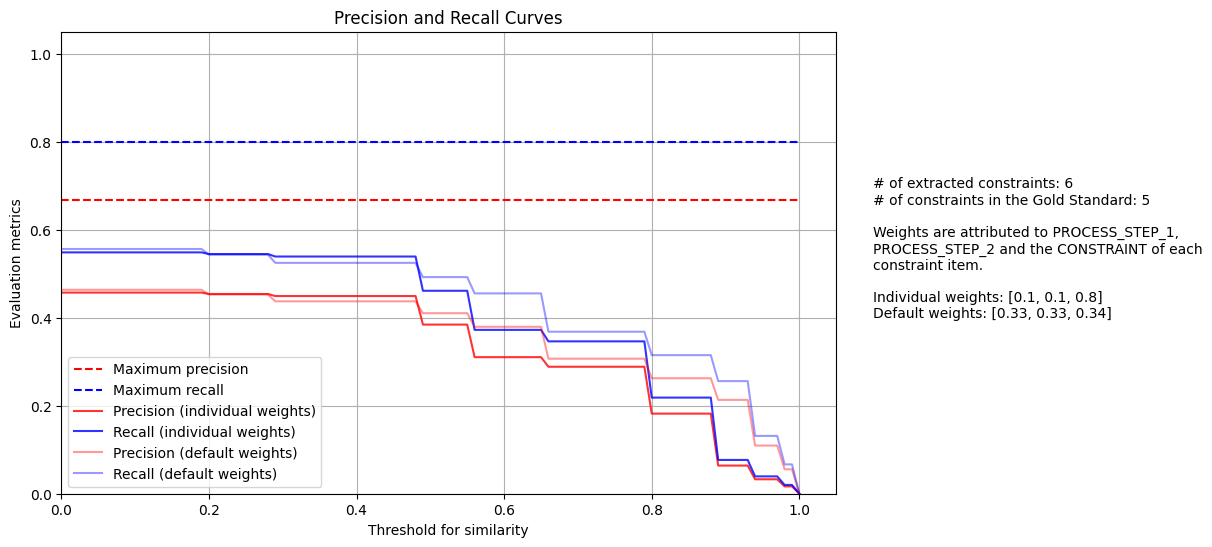

In [ ]:
evlt_prec_rec(constraints_dummy_cdm, constraints_gs_cdm, matches_step_1, matches_step_2, matches_constraints, individual_weights=True, weights=[0.1, 0.1, 0.8], hard_cut=True, threshold=0.8, plot_curves=True)


![](../reports/presentations/20231205/5.png)
![](../reports/presentations/20231205/6.png)


![](../reports/presentations/20231205/7.png)